<a href="https://colab.research.google.com/github/sira4154/Coursera_Capstone/blob/main/Capstone_Project_The_Battle_of_the_Neighborhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

#Food location in Bangkok feel like home

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Bangkok, the capital of Thailand, is one of the world's top tourist destination cities. Bangkok is a truly cosmopolitan city, home to people from around the world. As a consequence, Bangkok is various in culture and cuisine.
there are many different types of food such as Chinese food, Japanese food, and so on.

For This project, I would like to recommend it to tourists or those who have to transfer to work in Bangkok for a long time. this block will help visitor for finding the national restaurants location as you prefer by identifying the most type of food in which district and it's part of the decision. that help you choose to stay in which district with a restaurant in the way that you are need.




## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing restaurants in each districts of Bangkok (which can identify type of restaurant)
* number and name districts in Bangkok  

We decided to use districts point of center locations, to define cluster.

Following data sources will be needed to extract/generate the required information:
* centers of districts will be generated name, latitude and longitude by webscarping beautifulsoup from Wikipedia:https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok 
* number of restaurants and their type and location in every districts will be obtained using **Foursquare API**

###import library

In [1]:
!pip install bs4 #install BeautifulSoup library

In [2]:
from bs4 import BeautifulSoup # this module helps in web scrapping.
import requests  # this module helps us to download a web page
import pandas as pd
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
from pandas.io.json import json_normalize
import json
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"


### Districts in Bangkok

Let's create name,latitude and longitude coordinates for centroids of our districts in Bangkok by use beautifulSoup library for srapping data from Wikipedia:https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok


###Scraping Dataset from wikipedia

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok"

In [4]:
data  = requests.get(url).text

In [5]:
soup = BeautifulSoup(data,"html5lib")

In [6]:
tables = soup.find_all('table') # in html table is represented by the tag <table>

In [7]:
len(tables)

2

In [8]:
for index,table in enumerate(tables):
    if ("wikitable sortable" in str(table)):
        table_index = index
print(table_index)

0


###Create dataframe District

this section create dataframe from pandas library that table contain District , Map ,Postcode ,Thai ,Population ,No. of Subdistricts ,Latitude ,Longitude and No.ofSubdistricts

In [9]:
neighborhoods_bangkok = pd.DataFrame(columns=["District", "Map", "Postcode","Thai","Population","No. of Subdistricts",
                                              "Latitude","Longitude"])

for row in tables[table_index].tbody.find_all("tr"):
    col = row.find_all("td")
    if (col != []):
        district = col[0].text
        map = col[1].text
        postcode = col[2].text
        thai = col[3].text
        population = col[4].text
        no_subdistricts = col[5].text
        latitude = col[6].text
        longitude = col[7].text.strip()
        neighborhoods_bangkok = neighborhoods_bangkok.append({"District":district, "Map":map, "Postcode":postcode,"Thai":thai, "Population":population,"No.ofSubdistricts":no_subdistricts,
                                              "Latitude":latitude,"Longitude":longitude}, ignore_index=True)

neighborhoods_bangkok.head(5)

,District,Map,Postcode,Thai,Population,No. of Subdistricts,Latitude,Longitude,No.ofSubdistricts
0,Bang Bon,50,10150,บางบอน,"105,161",NaN,13.6592\n,100.3991,4\n
1,Bang Kapi,6,10240,บางกะปิ,"148,465",NaN,13.765833\n,100.647778,2\n
2,Bang Khae,40,10160,บางแค,"191,781",NaN,13.696111\n,100.409444,4\n
3,Bang Khen,5,10220,บางเขน,"189,539",NaN,13.873889\n,100.596389,2\n
4,Bang Kho Laem,31,10120,บางคอแหลม,"94,956",NaN,13.693333\n,100.5025,3\n


### Extract feature and clean the data 

Drop the column not need and claen some strange data

In [10]:
neighborhoods_bangkok.drop(columns=["No. of Subdistricts","No.ofSubdistricts"],inplace= True)
neighborhoods_bangkok["Population"] = neighborhoods_bangkok["Population"].str.replace(',', '')
neighborhoods_bangkok["Latitude"] = neighborhoods_bangkok["Latitude"].str.replace('\n', '')
neighborhoods_bangkok["Longitude"] = neighborhoods_bangkok["Longitude"].str.replace('\n', '')
neighborhoods_bangkok["Postcode"] = neighborhoods_bangkok["Postcode"].str.replace('\n', '')
neighborhoods_bangkok.head(20)

,District,Map,Postcode,Thai,Population,Latitude,Longitude
0,Bang Bon,50,10150,บางบอน,105161,13.6592,100.3991
1,Bang Kapi,6,10240,บางกะปิ,148465,13.765833,100.647778
2,Bang Khae,40,10160,บางแค,191781,13.696111,100.409444
3,Bang Khen,5,10220,บางเขน,189539,13.873889,100.596389
4,Bang Kho Laem,31,10120,บางคอแหลม,94956,13.693333,100.5025
5,Bang Khun Thian,21,10150,บางขุนเทียน,165491,13.660833,100.435833
6,Bang Na,47,10260,บางนา,95912,13.680081,100.5918
7,Bang Phlat,25,10700,บางพลัด,99273,13.793889,100.505
8,Bang Rak,4,10500,บางรัก,45875,13.730833,100.524167
9,Bang Sue,29,10800,บางซื่อ,132234,13.809722,100.537222


Check types of column 

In [11]:
neighborhoods_bangkok.dtypes

District      object
Map           object
Postcode      object
Thai          object
Population    object
Latitude      object
Longitude     object
dtype: object

In [12]:
neighborhoods_bangkok["Map"] = neighborhoods_bangkok['Map'].astype('int')
neighborhoods_bangkok["Population"] = neighborhoods_bangkok['Population'].astype('int')
neighborhoods_bangkok["Latitude"] = neighborhoods_bangkok['Latitude'].astype('float')
neighborhoods_bangkok["Longitude"] = neighborhoods_bangkok['Longitude'].astype('float')
neighborhoods_bangkok.dtypes

District       object
Map             int64
Postcode       object
Thai           object
Population      int64
Latitude      float64
Longitude     float64
dtype: object

setting index

In [13]:
neighborhoods_bangkok.set_index("Map",inplace=True)
neighborhoods_bangkok.head()

,District,Postcode,Thai,Population,Latitude,Longitude
Map,,,,,,
50,Bang Bon,10150,บางบอน,105161,13.659200,100.399100
6,Bang Kapi,10240,บางกะปิ,148465,13.765833,100.647778
40,Bang Khae,10160,บางแค,191781,13.696111,100.409444
5,Bang Khen,10220,บางเขน,189539,13.873889,100.596389
31,Bang Kho Laem,10120,บางคอแหลม,94956,13.693333,100.502500


Sort data

In [14]:
neighborhoods_bangkok.sort_values(by=["Map"],inplace=True)

 ### Visualization Bangkok district
 Let's visualize the data of bangkok dictrict location.

In [15]:
address = 'Bangkok, Thailand'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitudes = location.latitude
longitudes = location.longitude
print('The geograpical coordinate of Bangkok, Thailand are {}, {}.'.format(latitudes, longitudes))

The geograpical coordinate of Bangkok, Thailand are 13.7544238, 100.4930399.


In [16]:
# create map of New York using latitude and longitude values
map_bangkok = folium.Map(location=[latitudes, longitudes], zoom_start=11)

 #add markers to map
for lat, lng, district in zip(neighborhoods_bangkok['Latitude'], neighborhoods_bangkok['Longitude'],neighborhoods_bangkok['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bangkok)  
    
map_bangkok

## Methodology <a name="methodology"></a>

In this project, we will detect the data that indicates the country of the restaurant in the Bangkok district. So it must match the purpose of the project to find the type of restaurant which contain in each district.

Analytical Approach
The total number of the district in Bangkok are 50 so we need to find a way to cluster them based on their similarities, that are the number and the kind of restaurant. Briefly, after some steps of Data Cleaning and Data Exploration choose only national restaurants except Thai food because we would like to recommend foreigners to find type of restaurant which fimilar their country, this project will use a K-Means algorithm to extract the clusters, produce a map and make an argument on the final result.




### Foursquare

Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on restaurants in each neighborhood.

We're interested in venues in 'food' category, but only those that are proper restaurants - coffe shops, pizza places, bakeries etc. are not direct competitors so we don't care about those. So we will include in out list only venues that have 'restaurant' in category name, and we'll make sure to detect and include all the subcategories of specific nationality restaurants category, as we need info Restaurants from various countries in the neighborhood except Thai restaurants.

In [17]:
CLIENT_ID = 'OFAU3SDP4NPVZXTJCNWHL4RU23LQZCY3NYWO0VRDJYUWPRXP' # your Foursquare ID
CLIENT_SECRET = 'SQMJCPSAWI4THEXLU2CLTUA3YHXEKBFCMX4AJW2ICJZD1TWH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + 'OFAU3SDP4NPVZXTJCNWHL4RU23LQZCY3NYWO0VRDJYUWPRXP')
print('CLIENT_SECRET:' + 'SQMJCPSAWI4THEXLU2CLTUA3YHXEKBFCMX4AJW2ICJZD1TWH')

Your credentails:
CLIENT_ID: OFAU3SDP4NPVZXTJCNWHL4RU23LQZCY3NYWO0VRDJYUWPRXP
CLIENT_SECRET:SQMJCPSAWI4THEXLU2CLTUA3YHXEKBFCMX4AJW2ICJZD1TWH


In [18]:
neighborhood_latitude = neighborhoods_bangkok.loc[1, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods_bangkok.loc[1, 'Longitude'] # neighborhood longitude value

District_name = neighborhoods_bangkok.loc[1, 'District'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(District_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Phra Nakhon are 13.764444, 100.499167.


In [19]:
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=OFAU3SDP4NPVZXTJCNWHL4RU23LQZCY3NYWO0VRDJYUWPRXP&client_secret=SQMJCPSAWI4THEXLU2CLTUA3YHXEKBFCMX4AJW2ICJZD1TWH&ll=13.696944\n,100.543056&v=20180605&radius=500&limit=100'

In [20]:
results = requests.get(url).json()
#results

In [ ]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [ ]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Recreational Bangkok Biking,Bike Rental / Bike Share,13.698552,100.544010
1,Tawandang German Brewery (โรงเบียร์เยอรมันตะวั...,Brewery,13.696742,100.545958
2,Hachiban Ramen (ฮะจิบัง ราเมน),Ramen Restaurant,13.697124,100.540969
3,Fuji (ฟูจิ),Japanese Restaurant,13.697371,100.541175
4,Moo-Hun-Song-Pee-Nong (หมูหันสองพี่น้อง),Chinese Restaurant,13.698668,100.542877


In [ ]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

27 venues were returned by Foursquare.


In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
bangkok_venues = getNearbyVenues(names=neighborhoods_bangkok['District'],
                            latitudes=neighborhoods_bangkok['Latitude'],
                            longitudes=neighborhoods_bangkok['Longitude'])

Phra Nakhon
Dusit
Nong Chok
Bang Rak
Bang Khen
Bang Kapi
Pathum Wan
Pom Prap Sattru Phai
Phra Khanong
Min Buri
Lat Krabang
Yan Nawa
Samphanthawong
Phaya Thai
Thon Buri
Bangkok Yai
Huai Khwang
Khlong San
Taling Chan
Bangkok Noi
Bang Khun Thian
Phasi Charoen
Nong Khaem
Rat Burana
Bang Phlat
Din Daeng
Bueng Kum
Sathon
Bang Sue
Chatuchak
Bang Kho Laem
Prawet
Khlong Toei
Suan Luang
Chom Thong
Don Mueang
Ratchathewi
Lat Phrao
Watthana
Bang Khae
Lak Si
Sai Mai
Khan Na Yao
Saphan Sung
Wang Thonglang
Khlong Sam Wa
Bang Na
Thawi Watthana
Thung Khru
Bang Bon


In [ ]:
print(bangkok_venues.shape)
bangkok_venues.head()

(1157, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Phra Nakhon,13.764444,100.499167,Adhere the 13th Blues Bar,13.763043,100.498839,Jazz Club
1,Phra Nakhon,13.764444,100.499167,Teddy The Bake,13.766085,100.499858,Café
2,Phra Nakhon,13.764444,100.499167,Beer and Cider House,13.762882,100.498841,Beer Bar
3,Phra Nakhon,13.764444,100.499167,Khaosan Baan Thai,13.766141,100.497963,Hostel
4,Phra Nakhon,13.764444,100.499167,Casa Nithra Hotel,13.765834,100.500721,Hotel


In [ ]:
print('There are {} uniques categories.'.format(bangkok_venues['Venue Category'].value_counts()))

There are Noodle House         131
Convenience Store     77
Coffee Shop           74
Thai Restaurant       69
Café                  51
                    ... 
Movie Theater          1
Nightclub              1
Pool                   1
Garden                 1
Salad Place            1
Name: Venue Category, Length: 167, dtype: int64 uniques categories.


### Extract and clean the data from foursqure
Let's extract the category type of restaurant, separated by country In some venues category type list we have some restaurants that can estimate that it is suitable for which country

In [ ]:
bangkok_Venues_only_restaurant = bangkok_venues[bangkok_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
bangkok_Venues_only_restaurant.index = np.arange(1, len(bangkok_Venues_only_restaurant )+1)

In [ ]:
print (bangkok_Venues_only_restaurant['Venue Category'].value_counts())

Thai Restaurant                  69
Asian Restaurant                 45
Chinese Restaurant               31
Japanese Restaurant              29
Som Tum Restaurant               22
Fast Food Restaurant             20
Hotpot Restaurant                19
Seafood Restaurant               16
Restaurant                       13
Sushi Restaurant                  9
Italian Restaurant                9
Dim Sum Restaurant                9
Ramen Restaurant                  7
Shabu-Shabu Restaurant            7
Vietnamese Restaurant             6
Korean Restaurant                 5
Halal Restaurant                  4
Satay Restaurant                  2
Donburi Restaurant                2
Japanese Curry Restaurant         2
American Restaurant               2
Vegetarian / Vegan Restaurant     2
Udon Restaurant                   1
New American Restaurant           1
German Restaurant                 1
Mexican Restaurant                1
Mediterranean Restaurant          1
Tonkatsu Restaurant         

We have some categories that do not identify food countries. So we need to scan these categories which have any restaurant can identify food country by searching name restaurant in google.

In [ ]:
extract_restaurant = ["Asian Restaurant","Hotpot Restaurant","Fast Food Restaurant","Restaurant","Shabu-Shabu Restaurant","Halal Restaurant","Seafood Restaurant"]
asian_cate = bangkok_Venues_only_restaurant[bangkok_Venues_only_restaurant['Venue Category'].isin(extract_restaurant)]
asian_cate["Venue Category"].unique()

array(['Asian Restaurant', 'Halal Restaurant', 'Seafood Restaurant',
       'Hotpot Restaurant', 'Shabu-Shabu Restaurant',
       'Fast Food Restaurant', 'Restaurant'], dtype=object)

In [ ]:
asian_cate.to_excel('asian_cate.xlsx')

After we searching some keywords in the restaurant names for finding the type of restaurant next we will replace the category name to indicate food country

In [ ]:
chinese_th = ["โจ๊ก","ข้าวต้ม","Haidilao","โชคดี","ฮ่องเต้","เรือนหยก","เยาวราช","LonLon","Taiwan","Koa"]
vietnam_th = ["เฝอ"]
japan_th = ["Mo-Mo-Paradise","Shabushi","Pladib","Akiyoshi","Shibuya","Shabu","Sushi"]
American_th = ["แม็คโดนัลด์","KFC","Burger","Canyon","เคเอฟซี","A&W","CANYON","McDonald","Florida"]
india_th = ["โรตี","หมกไก่","ฮาลาล","มุสลิม","Muslim"]
europe_th = ["Verandah","YAZEE","TREEBOX","Emmie's","VOF","Number 9","BUNG","Cuisine","Clay"]

chinese = bangkok_Venues_only_restaurant[bangkok_Venues_only_restaurant['Venue'].str.contains('|'.join(chinese_th))]
ch = chinese["Venue"].values.tolist()
vietnam = bangkok_Venues_only_restaurant[bangkok_Venues_only_restaurant['Venue'].str.contains('|'.join(vietnam_th))]
vt = vietnam["Venue"].values.tolist()
japan = bangkok_Venues_only_restaurant[bangkok_Venues_only_restaurant['Venue'].str.contains('|'.join(japan_th))]
jp = japan["Venue"].values.tolist()
american = bangkok_Venues_only_restaurant[bangkok_Venues_only_restaurant['Venue'].str.contains('|'.join(American_th))]
usa = american["Venue"].values.tolist()
india = bangkok_Venues_only_restaurant[bangkok_Venues_only_restaurant['Venue'].str.contains('|'.join(india_th))]
ind = india["Venue"].values.tolist()
europe = bangkok_Venues_only_restaurant[bangkok_Venues_only_restaurant['Venue'].str.contains('|'.join(europe_th))]
eu = europe["Venue"].values.tolist()
print(ch)

['ข้าวต้มเพ่งเพ้ง', 'Khaotom Bawon (ข้าวต้มบวร)', 'โจ๊กสามย่าน', 'Chokdee Dimsum (โชคดีติ่มซำ)', 'Khaw Tom Heng Rim Nuun (ข้าวต้มแห้งริมหนน)', 'FuFu Taiwanese Shabu', 'ตึ๊ง ข้าวต้มหัวปลา หลังติดรถไฟ', 'เรือนหยก สุกี้โบราณ', 'Joke Moo Thong (โจ๊กหมูทอง)', 'ขาหมูฮ่องเต้', 'โจ๊กสยาม', 'โจ๊กหม้อดิน พัฒนาการ', 'ครัวข้าวต้มเจ้ใส', 'เฮงเฮงข้าวต้มปูดอง']


In [ ]:
for i in range(0,len(bangkok_Venues_only_restaurant)):
  #print (bangkok_Venues_only_restaurant['Venue'].iloc[i])
  if bangkok_Venues_only_restaurant['Venue'].iloc[i] in ch:
     bangkok_Venues_only_restaurant['Venue Category'].iloc[i] = "Chinese Restaurant"
  elif  bangkok_Venues_only_restaurant['Venue'].iloc[i] in vt:
     bangkok_Venues_only_restaurant['Venue Category'].iloc[i] = "Vietnamese Restaurant"
  elif  bangkok_Venues_only_restaurant['Venue'].iloc[i] in jp:
     bangkok_Venues_only_restaurant['Venue Category'].iloc[i] = "Japanese Restaurant"
  elif  bangkok_Venues_only_restaurant['Venue'].iloc[i] in usa:
     bangkok_Venues_only_restaurant['Venue Category'].iloc[i] = "American Restaurant"
  elif  bangkok_Venues_only_restaurant['Venue'].iloc[i] in ind:
     bangkok_Venues_only_restaurant['Venue Category'].iloc[i] = "Indian Restaurant"
  elif  bangkok_Venues_only_restaurant['Venue'].iloc[i] in eu:
     bangkok_Venues_only_restaurant['Venue Category'].iloc[i] = "European restaurant"

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Let recheck the quantity of food country again after We identify food country in category Asian Restaurant,Hotpot Restaurant,Fast Food Restaurant,Restaurant,Shabu-Shabu Restaurant,Halal Restaurant,Seafood Restaurant

In [ ]:
print (bangkok_Venues_only_restaurant['Venue Category'].value_counts())

Thai Restaurant                  66
Japanese Restaurant              44
Chinese Restaurant               44
Asian Restaurant                 38
Som Tum Restaurant               22
American Restaurant              18
Hotpot Restaurant                16
Seafood Restaurant               15
Italian Restaurant                9
Dim Sum Restaurant                8
Restaurant                        8
Ramen Restaurant                  7
Fast Food Restaurant              6
Vietnamese Restaurant             6
Korean Restaurant                 5
Sushi Restaurant                  4
European restaurant               3
Satay Restaurant                  2
Donburi Restaurant                2
Japanese Curry Restaurant         2
Indian Restaurant                 2
Vegetarian / Vegan Restaurant     2
Udon Restaurant                   1
New American Restaurant           1
German Restaurant                 1
Mexican Restaurant                1
Halal Restaurant                  1
Mediterranean Restaurant    

In [ ]:
print('There are {} unique categories.'.format(len(bangkok_Venues_only_restaurant['Venue Category'].unique())))

There are 31 unique categories.


Create Food country column

In [ ]:
bangkok_Venues_only_restaurant["Food country"] = bangkok_Venues_only_restaurant["Venue Category"].copy()

In [ ]:
bangkok_Venues_only_restaurant.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Food country
1,Phra Nakhon,13.764444,100.499167,Thamna Hometaurant (ทำนา),13.765223,100.500124,Vegetarian / Vegan Restaurant,Vegetarian / Vegan Restaurant
2,Phra Nakhon,13.764444,100.499167,Sushi Express,13.761450,100.499306,Japanese Restaurant,Japanese Restaurant
3,Phra Nakhon,13.764444,100.499167,ข้าวต้มเพ่งเพ้ง,13.761792,100.499359,Chinese Restaurant,Chinese Restaurant
4,Phra Nakhon,13.764444,100.499167,Joy Luck Club พระอาทิตย์,13.763594,100.496110,Thai Restaurant,Thai Restaurant
5,Phra Nakhon,13.764444,100.499167,ต้มยำกุ้ง บางลำพู,13.760900,100.498337,Thai Restaurant,Thai Restaurant


Change name category for making the data indicate only name of country 

In [ ]:
bangkok_Venues_only_restaurant['Food country'] = bangkok_Venues_only_restaurant['Food country'].apply(lambda x:"Chinese Restaurant"  if x == "Dim Sum Restaurant" or x =="Taiwanese Restaurant"or x=="Cantonese Restaurant" 
                                              or x == "Taiwanese Restaurant" or x == "Hainan Restaurant" or x == "Dumpling Restaurant" or x == "Szechuan Restaurant" else x)
bangkok_Venues_only_restaurant['Food country'] = bangkok_Venues_only_restaurant['Food country'].apply(lambda x:"Japanese Restaurant"  if x == "Sushi Restaurant" or x =="Ramen Restaurant"or x=="Tonkatsu Restaurant" 
                                              or x == "Kaiseki Restaurant" or x == "Japanese Curry Restaurant" or x=="Soba Restaurant"or x =="Yoshoku Restaurant" or x == "Donburi Restaurant" else x)
bangkok_Venues_only_restaurant['Food country'] = bangkok_Venues_only_restaurant['Food country'].apply(lambda x:"Indian Restaurant"  if x == "South Indian Restaurant" else x)
bangkok_Venues_only_restaurant['Food country'] = bangkok_Venues_only_restaurant['Food country'].apply(lambda x:"European restaurant"  if x == "Italian Restaurant" or x == "French Restaurant"or x == "German Restaurant" 
                                              or x== "Modern European Restaurant" or x == "Greek Restaurant" or x =="Eastern European Restaurant" or x == "Mediterranean Restaurant"or x =="Swiss Restaurant" or x == "Cajun / Creole Restaurant"
                                              or x == "Spanish Restaurant" else x)
bangkok_Venues_only_restaurant['Food country'] = bangkok_Venues_only_restaurant['Food country'].apply(lambda x:"American Restaurant"  if x == "New American Restaurant" or x == "Mexican Restaurant"else x)
print (bangkok_Venues_only_restaurant['Food country'].value_counts()) 

Thai Restaurant                  66
Japanese Restaurant              60
Chinese Restaurant               53
Asian Restaurant                 38
Som Tum Restaurant               22
American Restaurant              20
Hotpot Restaurant                16
Seafood Restaurant               15
European restaurant              14
Restaurant                        8
Fast Food Restaurant              6
Vietnamese Restaurant             6
Korean Restaurant                 5
Vegetarian / Vegan Restaurant     2
Satay Restaurant                  2
Indian Restaurant                 2
Udon Restaurant                   1
Halal Restaurant                  1
Comfort Food Restaurant           1
Name: Food country, dtype: int64


Remove some category cannot indicate country and related Thai food 

In [ ]:
listnotuse = ["Thai Restaurant","Restaurant","Som Tum Restaurant","Seafood Restaurant","Fast Food Restaurant","Hotpot Restaurant","Shabu-Shabu Restaurant","Vegetarian / Vegan Restaurant"
                  ,"Satay Restaurant","Halal Restaurant","Molecular Gastronomy Restaurant","Asian Restaurant","Middle Eastern Restaurant","Comfort Food Restaurant",
                  "Southern / Soul Food Restaurant","Udon Restaurant"]
for i in listnotuse:
  bangkok_Venues_only_restaurant = bangkok_Venues_only_restaurant[bangkok_Venues_only_restaurant["Food country"] != i]
print (bangkok_Venues_only_restaurant['Food country'].value_counts())

Japanese Restaurant      60
Chinese Restaurant       53
American Restaurant      20
European restaurant      14
Vietnamese Restaurant     6
Korean Restaurant         5
Indian Restaurant         2
Name: Food country, dtype: int64


After finish extract and clean the data from foursquare.
We will get six different types of restaurants 


In [ ]:
bangkok_Venues_Top10 = bangkok_Venues_only_restaurant['Food country'].value_counts()[0:10].to_frame(name='frequency')
bangkok_Venues_Top10=bangkok_Venues_Top10.reset_index()
bangkok_Venues_Top10.rename(index=str, columns={"index": "Food country", "frequency": "Frequency"}, inplace=True)
bangkok_Venues_Top10

,Food country,Frequency
0,Japanese Restaurant,60
1,Chinese Restaurant,53
2,American Restaurant,20
3,European restaurant,14
4,Vietnamese Restaurant,6
5,Korean Restaurant,5
6,Indian Restaurant,2


Create histogram chart for show type of restaurant frequently 

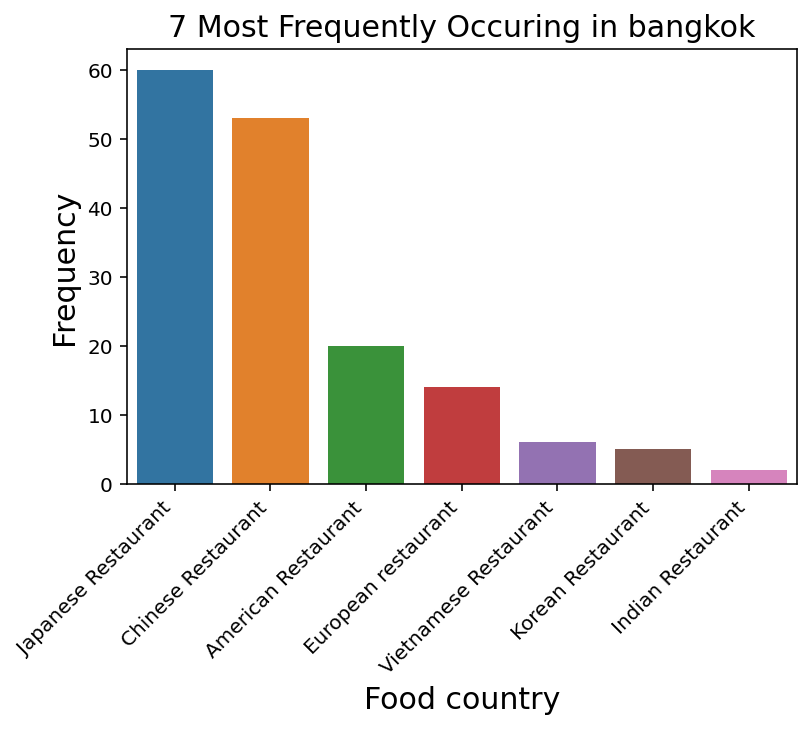

<Figure size 1296x504 with 0 Axes>

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

s=sns.barplot(x="Food country", y="Frequency", data=bangkok_Venues_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('7 Most Frequently Occuring in bangkok', fontsize=15)
plt.xlabel("Food country", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues1.png", dpi=300)
fig = plt.figure(figsize=(18,7))
plt.show()

In [ ]:
print ("Shape of the Data-Frame with Venue Category only Restaurant: ", bangkok_Venues_only_restaurant.shape)
bangkok_Venues_only_restaurant.head(10)

Shape of the Data-Frame with Venue Category only Restaurant:  (160, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Food country
2,Phra Nakhon,13.764444,100.499167,Sushi Express,13.761450,100.499306,Japanese Restaurant,Japanese Restaurant
3,Phra Nakhon,13.764444,100.499167,ข้าวต้มเพ่งเพ้ง,13.761792,100.499359,Chinese Restaurant,Chinese Restaurant
6,Phra Nakhon,13.764444,100.499167,Roti-Mataba (โรตี-มะตะบะ),13.763593,100.495590,Indian Restaurant,Indian Restaurant
7,Phra Nakhon,13.764444,100.499167,Khaotom Bawon (ข้าวต้มบวร),13.761043,100.500233,Chinese Restaurant,Chinese Restaurant
15,Bang Rak,13.730833,100.524167,China Palace (ไชน่าพาเลซ),13.731122,100.523996,Chinese Restaurant,Chinese Restaurant
17,Bang Rak,13.730833,100.524167,ฮกหูฉลาม (Hok Shark Fin) 福,13.728625,100.527474,Chinese Restaurant,Chinese Restaurant
19,Bang Rak,13.730833,100.524167,ครัวปักกิ่ง,13.734883,100.526153,Chinese Restaurant,Chinese Restaurant
23,Bang Khen,13.873889,100.596389,แหนมเนืองคุณนิด (อาหารเวียดนาม),13.874746,100.600030,Vietnamese Restaurant,Vietnamese Restaurant
25,Bang Kapi,13.765833,100.647778,Shabushi (ชาบูชิ),13.767332,100.643828,Japanese Restaurant,Japanese Restaurant
27,Bang Kapi,13.765833,100.647778,Hachiban Ramen (ฮะจิบัง ราเมน),13.767572,100.643591,Ramen Restaurant,Japanese Restaurant


In [ ]:
bangkok_Venues_restaurant = bangkok_Venues_only_restaurant.groupby(['Neighborhood'])['Food country'].apply(lambda x: x[x.str.contains('Restaurant')].count())

In [ ]:
bangkok_Venues_restaurant

Neighborhood
Bang Bon                 1
Bang Kapi                3
Bang Khae                2
Bang Khen                1
Bang Kho Laem            4
Bang Khun Thian          6
Bang Phlat               1
Bang Rak                 3
Bangkok Noi              1
Bangkok Yai              2
Bueng Kum                1
Chatuchak                1
Huai Khwang              2
Khan Na Yao              8
Khlong Sam Wa            3
Khlong San               4
Khlong Toei              1
Lak Si                   3
Lat Phrao                2
Pathum Wan              16
Phasi Charoen            9
Phaya Thai              17
Phra Khanong             3
Phra Nakhon              4
Pom Prap Sattru Phai     7
Prawet                   1
Rat Burana               2
Ratchathewi              4
Samphanthawong           4
Saphan Sung              1
Sathon                   7
Suan Luang               3
Thawi Watthana           2
Thung Khru               1
Wang Thonglang           3
Watthana                 6
Yan Nawa       

In [ ]:
bangkok_Venues_restaurant_df  = bangkok_Venues_restaurant.to_frame().reset_index()
bangkok_Venues_restaurant_df.columns = ['Neighborhood', 'Number of Restaurant']
bangkok_Venues_restaurant_df.index = np.arange(1, len(bangkok_Venues_restaurant_df)+1)
list_rest_no =bangkok_Venues_restaurant_df['Number of Restaurant'].to_list()
list_dist =bangkok_Venues_restaurant_df['Neighborhood'].to_list()

## Analysis <a name="analysis"></a>

After finish explores data from foursquare section we will receive 7 food countries for analysis.
Next step in analysis section Let prepare the data to be in  ready to use the format

Use one hot encoding technique to make data in numeric format.

In [ ]:
# one hot encoding
bangkok_onehot = pd.get_dummies(bangkok_Venues_only_restaurant[['Food country']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bangkok_onehot['Neighborhood'] = bangkok_Venues_only_restaurant['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bangkok_onehot.columns[-1]] + list(bangkok_onehot.columns[:-1])
bangkok_onehot = bangkok_onehot[fixed_columns]

bangkok_onehot.head()

,Neighborhood,American Restaurant,Chinese Restaurant,European restaurant,Indian Restaurant,Japanese Restaurant,Korean Restaurant,Vietnamese Restaurant
2,Phra Nakhon,0,0,0,0,1,0,0
3,Phra Nakhon,0,1,0,0,0,0,0
6,Phra Nakhon,0,0,0,1,0,0,0
7,Phra Nakhon,0,1,0,0,0,0,0
15,Bang Rak,0,1,0,0,0,0,0


In [ ]:
bangkok_onehot.shape

(160, 8)

Groupby the type of restaurant

In [ ]:
bangkok_grouped = bangkok_onehot.groupby('Neighborhood').mean().reset_index()
bangkok_grouped

,Neighborhood,American Restaurant,Chinese Restaurant,European restaurant,Indian Restaurant,Japanese Restaurant,Korean Restaurant,Vietnamese Restaurant
0,Bang Bon,0.000000,0.000000,0.000000,0.0000,1.000000,0.000000,0.000000
1,Bang Kapi,0.000000,0.000000,0.000000,0.0000,0.666667,0.333333,0.000000
2,Bang Khae,0.500000,0.000000,0.000000,0.0000,0.500000,0.000000,0.000000
3,Bang Khen,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,1.000000
4,Bang Kho Laem,0.250000,0.500000,0.000000,0.0000,0.000000,0.000000,0.250000
5,Bang Khun Thian,0.166667,0.166667,0.000000,0.0000,0.666667,0.000000,0.000000
6,Bang Phlat,1.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
7,Bang Rak,0.000000,1.000000,0.000000,0.0000,0.000000,0.000000,0.000000
8,Bangkok Noi,0.000000,1.000000,0.000000,0.0000,0.000000,0.000000,0.000000
9,Bangkok Yai,0.000000,1.000000,0.000000,0.0000,0.000000,0.000000,0.000000


In [ ]:
bangkok_grouped.shape

(37, 8)

Show the top 7 food country in each distict

In [ ]:
num_top_venues = 7

for hood in bangkok_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = bangkok_grouped[bangkok_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bang Bon----
                   venue  freq
0    Japanese Restaurant   1.0
1    American Restaurant   0.0
2     Chinese Restaurant   0.0
3    European restaurant   0.0
4      Indian Restaurant   0.0
5      Korean Restaurant   0.0
6  Vietnamese Restaurant   0.0


----Bang Kapi----
                   venue  freq
0    Japanese Restaurant  0.67
1      Korean Restaurant  0.33
2    American Restaurant  0.00
3     Chinese Restaurant  0.00
4    European restaurant  0.00
5      Indian Restaurant  0.00
6  Vietnamese Restaurant  0.00


----Bang Khae----
                   venue  freq
0    American Restaurant   0.5
1    Japanese Restaurant   0.5
2     Chinese Restaurant   0.0
3    European restaurant   0.0
4      Indian Restaurant   0.0
5      Korean Restaurant   0.0
6  Vietnamese Restaurant   0.0


----Bang Khen----
                   venue  freq
0  Vietnamese Restaurant   1.0
1    American Restaurant   0.0
2     Chinese Restaurant   0.0
3    European restaurant   0.0
4      Indian Restaurant

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

As previous markdown. We use this data to create data frame

In [ ]:
num_top_venues = 7

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bangkok_grouped['Neighborhood']

for ind in np.arange(bangkok_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bangkok_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(23)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,Bang Bon,Japanese Restaurant,Vietnamese Restaurant,Korean Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant,American Restaurant
1,Bang Kapi,Japanese Restaurant,Korean Restaurant,Vietnamese Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant,American Restaurant
2,Bang Khae,Japanese Restaurant,American Restaurant,Vietnamese Restaurant,Korean Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant
3,Bang Khen,Vietnamese Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant,American Restaurant
4,Bang Kho Laem,Chinese Restaurant,Vietnamese Restaurant,American Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,European restaurant
5,Bang Khun Thian,Japanese Restaurant,Chinese Restaurant,American Restaurant,Vietnamese Restaurant,Korean Restaurant,Indian Restaurant,European restaurant
6,Bang Phlat,American Restaurant,Vietnamese Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant
7,Bang Rak,Chinese Restaurant,Vietnamese Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,European restaurant,American Restaurant
8,Bangkok Noi,Chinese Restaurant,Vietnamese Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,European restaurant,American Restaurant
9,Bangkok Yai,Chinese Restaurant,Vietnamese Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,European restaurant,American Restaurant


In [ ]:
neighborhoods_venues_sorted.shape

(37, 8)

###Clustering
To analyze food country in the neighborhood of Bangkok I will use a K-means clustering technic which in part of unsupervised learning. The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable K. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity.

###Elbow method
The first step we will use elbow method for identify the best of K value

In [ ]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(bangkok_grouped.drop('Neighborhood', 1))
    distortions.append(kmeanModel.inertia_)

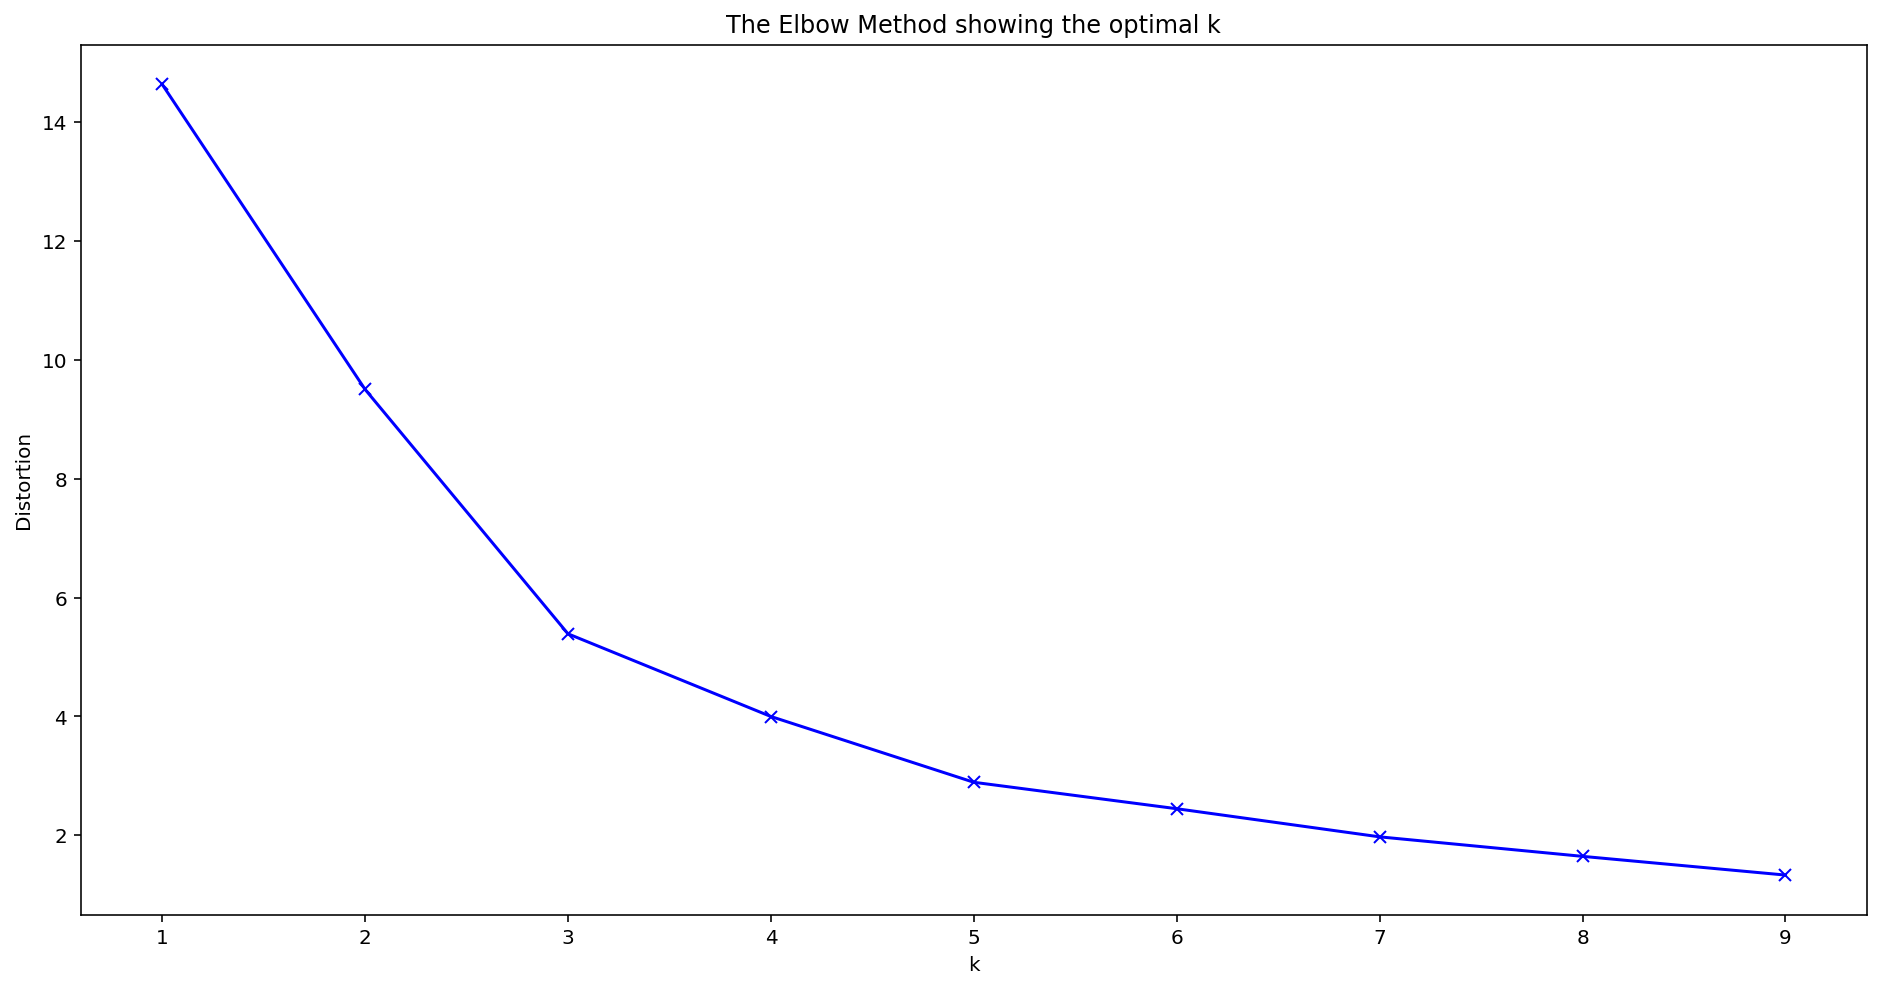

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

From the plot up here, I can easily say that the best K is 5.
Now it's time to run the kmeans algorithm:

### Kmeans clustering

In [ ]:
# set number of clusters (I choose 5)
kclusters = 5

bangkok_grouped_clustering = bangkok_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bangkok_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 0, 0, 1, 2, 3, 3, 3], dtype=int32)

In [ ]:
bangkok_merged = neighborhoods_bangkok
bangkok_merged.head(10)

,District,Postcode,Thai,Population,Latitude,Longitude
Map,,,,,,
1,Phra Nakhon,10200,พระนคร,57876,13.764444,100.499167
2,Dusit,10300,ดุสิต,107655,13.776944,100.520556
3,Nong Chok,10530,หนองจอก,157138,13.855556,100.862500
4,Bang Rak,10500,บางรัก,45875,13.730833,100.524167
5,Bang Khen,10220,บางเขน,189539,13.873889,100.596389
6,Bang Kapi,10240,บางกะปิ,148465,13.765833,100.647778
7,Pathum Wan,10330,ปทุมวัน,53263,13.744942,100.522200
8,Pom Prap Sattru Phai,10100,ป้อมปราบศัตรูพ่าย,51006,13.758056,100.513056
9,Phra Khanong,10260,พระโขนง,93482,13.702222,100.601667


In [ ]:
neighborhoods_venues_sorted_w_clusters = neighborhoods_venues_sorted

Add cluster label

In [ ]:
neighborhoods_venues_sorted_w_clusters.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted_w_clusters.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,1,Bang Bon,Japanese Restaurant,Vietnamese Restaurant,Korean Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant,American Restaurant
1,1,Bang Kapi,Japanese Restaurant,Korean Restaurant,Vietnamese Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant,American Restaurant
2,1,Bang Khae,Japanese Restaurant,American Restaurant,Vietnamese Restaurant,Korean Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant
3,0,Bang Khen,Vietnamese Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant,American Restaurant
4,0,Bang Kho Laem,Chinese Restaurant,Vietnamese Restaurant,American Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,European restaurant


Add the Postcode,thai,Population,Latitude and Longitude

In [ ]:
bangkok_merged.rename(columns={'District':'Neighborhood'}, inplace=True)

bangkok_merged = bangkok_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

bangkok_merged.head(10)

,Neighborhood,Postcode,Thai,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
Map,,,,,,,,,,,,,,
1,Phra Nakhon,10200,พระนคร,57876,13.764444,100.499167,4.0,Chinese Restaurant,Japanese Restaurant,Indian Restaurant,Vietnamese Restaurant,Korean Restaurant,European restaurant,American Restaurant
2,Dusit,10300,ดุสิต,107655,13.776944,100.520556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Nong Chok,10530,หนองจอก,157138,13.855556,100.862500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Bang Rak,10500,บางรัก,45875,13.730833,100.524167,3.0,Chinese Restaurant,Vietnamese Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,European restaurant,American Restaurant
5,Bang Khen,10220,บางเขน,189539,13.873889,100.596389,0.0,Vietnamese Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant,American Restaurant
6,Bang Kapi,10240,บางกะปิ,148465,13.765833,100.647778,1.0,Japanese Restaurant,Korean Restaurant,Vietnamese Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant,American Restaurant
7,Pathum Wan,10330,ปทุมวัน,53263,13.744942,100.522200,4.0,Chinese Restaurant,Japanese Restaurant,Korean Restaurant,Indian Restaurant,Vietnamese Restaurant,European restaurant,American Restaurant
8,Pom Prap Sattru Phai,10100,ป้อมปราบศัตรูพ่าย,51006,13.758056,100.513056,4.0,Chinese Restaurant,Japanese Restaurant,European restaurant,American Restaurant,Vietnamese Restaurant,Korean Restaurant,Indian Restaurant
9,Phra Khanong,10260,พระโขนง,93482,13.702222,100.601667,2.0,American Restaurant,European restaurant,Vietnamese Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,Chinese Restaurant


Change type of cluster label to integer 

In [ ]:
bangkok_merged.dropna(axis=0,inplace=True)
bangkok_merged["Cluster Labels"] = bangkok_merged["Cluster Labels"].astype('int')
bangkok_merged.head(10)

,Neighborhood,Postcode,Thai,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
Map,,,,,,,,,,,,,,
1,Phra Nakhon,10200,พระนคร,57876,13.764444,100.499167,4,Chinese Restaurant,Japanese Restaurant,Indian Restaurant,Vietnamese Restaurant,Korean Restaurant,European restaurant,American Restaurant
4,Bang Rak,10500,บางรัก,45875,13.730833,100.524167,3,Chinese Restaurant,Vietnamese Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,European restaurant,American Restaurant
5,Bang Khen,10220,บางเขน,189539,13.873889,100.596389,0,Vietnamese Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant,American Restaurant
6,Bang Kapi,10240,บางกะปิ,148465,13.765833,100.647778,1,Japanese Restaurant,Korean Restaurant,Vietnamese Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant,American Restaurant
7,Pathum Wan,10330,ปทุมวัน,53263,13.744942,100.522200,4,Chinese Restaurant,Japanese Restaurant,Korean Restaurant,Indian Restaurant,Vietnamese Restaurant,European restaurant,American Restaurant
8,Pom Prap Sattru Phai,10100,ป้อมปราบศัตรูพ่าย,51006,13.758056,100.513056,4,Chinese Restaurant,Japanese Restaurant,European restaurant,American Restaurant,Vietnamese Restaurant,Korean Restaurant,Indian Restaurant
9,Phra Khanong,10260,พระโขนง,93482,13.702222,100.601667,2,American Restaurant,European restaurant,Vietnamese Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,Chinese Restaurant
12,Yan Nawa,10120,ยานนาวา,81521,13.696944,100.543056,4,Japanese Restaurant,Chinese Restaurant,American Restaurant,Korean Restaurant,Vietnamese Restaurant,Indian Restaurant,European restaurant
13,Samphanthawong,10100,สัมพันธวงศ์,27452,13.731389,100.514167,4,Chinese Restaurant,Japanese Restaurant,European restaurant,Vietnamese Restaurant,Korean Restaurant,Indian Restaurant,American Restaurant


## Results and Discussion <a name="results"></a>
This section will show the result after perform by K-mean clustering let’s take a look on a folium map:

In [ ]:
# create a map with folium
map_restaurants10 =  folium.Map(location=[latitudes, longitudes], zoom_start=11)
                               #attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")
#map_bangkok = folium.Map(location=[latitudes, longitudes], zoom_start=11)

# set color scheme for the five clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster in zip(bangkok_merged['Latitude'], 
                                  bangkok_merged['Longitude'], 
                                  bangkok_merged['Neighborhood'], 
                                  bangkok_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=list_rest_no[list_dist.index(poi)]*0.7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_restaurants10)
       
map_restaurants10

Next let take a look on 5 cluster

cluster 1

In [ ]:
bangkok_merged.loc[bangkok_merged['Cluster Labels'] == 0, bangkok_merged.columns[[0] + list(range(6, bangkok_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
Map,,,,,,,,,
5,Bang Khen,0,Vietnamese Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant,American Restaurant
24,Rat Burana,0,Vietnamese Restaurant,Chinese Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,European restaurant,American Restaurant
31,Bang Kho Laem,0,Chinese Restaurant,Vietnamese Restaurant,American Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,European restaurant
37,Ratchathewi,0,European restaurant,Vietnamese Restaurant,Korean Restaurant,Chinese Restaurant,American Restaurant,Japanese Restaurant,Indian Restaurant
45,Wang Thonglang,0,Vietnamese Restaurant,Japanese Restaurant,American Restaurant,Korean Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant


cluster 2

In [ ]:
bangkok_merged.loc[bangkok_merged['Cluster Labels'] == 1, bangkok_merged.columns[[0] + list(range(6, bangkok_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
Map,,,,,,,,,
6,Bang Kapi,1,Japanese Restaurant,Korean Restaurant,Vietnamese Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant,American Restaurant
14,Phaya Thai,1,Japanese Restaurant,Chinese Restaurant,European restaurant,Vietnamese Restaurant,Korean Restaurant,American Restaurant,Indian Restaurant
21,Bang Khun Thian,1,Japanese Restaurant,Chinese Restaurant,American Restaurant,Vietnamese Restaurant,Korean Restaurant,Indian Restaurant,European restaurant
22,Phasi Charoen,1,Japanese Restaurant,American Restaurant,Vietnamese Restaurant,Korean Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant
32,Prawet,1,Japanese Restaurant,Vietnamese Restaurant,Korean Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant,American Restaurant
40,Bang Khae,1,Japanese Restaurant,American Restaurant,Vietnamese Restaurant,Korean Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant
41,Lak Si,1,Japanese Restaurant,American Restaurant,Vietnamese Restaurant,Korean Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant
43,Khan Na Yao,1,Japanese Restaurant,American Restaurant,Vietnamese Restaurant,Korean Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant
44,Saphan Sung,1,Japanese Restaurant,Vietnamese Restaurant,Korean Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant,American Restaurant


cluster 3

In [ ]:
bangkok_merged.loc[bangkok_merged['Cluster Labels'] == 2, bangkok_merged.columns[[0] + list(range(6, bangkok_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
Map,,,,,,,,,
9,Phra Khanong,2,American Restaurant,European restaurant,Vietnamese Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,Chinese Restaurant
25,Bang Phlat,2,American Restaurant,Vietnamese Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant
27,Bueng Kum,2,American Restaurant,Vietnamese Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant
30,Chatuchak,2,American Restaurant,Vietnamese Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant
33,Khlong Toei,2,American Restaurant,Vietnamese Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,European restaurant,Chinese Restaurant


cluster 4

In [ ]:
bangkok_merged.loc[bangkok_merged['Cluster Labels'] == 3, bangkok_merged.columns[[0] + list(range(6, bangkok_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
Map,,,,,,,,,
4,Bang Rak,3,Chinese Restaurant,Vietnamese Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,European restaurant,American Restaurant
16,Bangkok Yai,3,Chinese Restaurant,Vietnamese Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,European restaurant,American Restaurant
20,Bangkok Noi,3,Chinese Restaurant,Vietnamese Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,European restaurant,American Restaurant
28,Sathon,3,Chinese Restaurant,Japanese Restaurant,Vietnamese Restaurant,Korean Restaurant,Indian Restaurant,European restaurant,American Restaurant
48,Thawi Watthana,3,Chinese Restaurant,Vietnamese Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,European restaurant,American Restaurant


cluster 5

In [ ]:
bangkok_merged.loc[bangkok_merged['Cluster Labels'] == 4, bangkok_merged.columns[[0] + list(range(6, bangkok_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
Map,,,,,,,,,
1,Phra Nakhon,4,Chinese Restaurant,Japanese Restaurant,Indian Restaurant,Vietnamese Restaurant,Korean Restaurant,European restaurant,American Restaurant
7,Pathum Wan,4,Chinese Restaurant,Japanese Restaurant,Korean Restaurant,Indian Restaurant,Vietnamese Restaurant,European restaurant,American Restaurant
8,Pom Prap Sattru Phai,4,Chinese Restaurant,Japanese Restaurant,European restaurant,American Restaurant,Vietnamese Restaurant,Korean Restaurant,Indian Restaurant
12,Yan Nawa,4,Japanese Restaurant,Chinese Restaurant,American Restaurant,Korean Restaurant,Vietnamese Restaurant,Indian Restaurant,European restaurant
13,Samphanthawong,4,Chinese Restaurant,Japanese Restaurant,European restaurant,Vietnamese Restaurant,Korean Restaurant,Indian Restaurant,American Restaurant
17,Huai Khwang,4,Japanese Restaurant,Chinese Restaurant,Vietnamese Restaurant,Korean Restaurant,Indian Restaurant,European restaurant,American Restaurant
18,Khlong San,4,Japanese Restaurant,Chinese Restaurant,European restaurant,Vietnamese Restaurant,Korean Restaurant,Indian Restaurant,American Restaurant
34,Suan Luang,4,Chinese Restaurant,European restaurant,Vietnamese Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant,American Restaurant
38,Lat Phrao,4,Japanese Restaurant,Chinese Restaurant,Vietnamese Restaurant,Korean Restaurant,Indian Restaurant,European restaurant,American Restaurant


From collecting the data name of restaurant that can be indicated food country 160 in Bangkok city by scaping 
from foursquare and use the Kmeans clustering technique that aims to partition n observations into k clusters in which 
each observation belongs to the cluster with the nearest mean and uses the elbow method to find the optimize of k-value 
As the result in folium map, you can see the 5 clusters which can be seen that Mostly Japanese food and Chinese food. 

## Conclusion <a name="conclusion"></a>

The purpose of this project is to introduce the neighborhood to tourists or foreigners who must live in Bangkok
and need to live in an area that there are foreign restaurants which have a type of restaurant nearly native domicile 
by using data from foursquare and then manage data in a format that meets the requirements and clustering each location to be appropriate.

However, the final decision on the optimal location will be made by the occupants. It may be base on specific characteristics
taking into consideration additional factors like attractiveness, environment, travel convenience, and so on.

